# Lab DL 02: Tuning Hyperparameter
Nama : Muhammad Fikrizza

NIM  : 2000018096


# **1. Introduction**

---
## Hyperparameter

Hyperparameters are variables whose value is set by the model designer before the learning process begins. These variables remain constant over the training process and directly impact the performance of your ML program.

hyperparameters might address model design questions such as:
* model (architectural) hyperparameters:
  * degree of polynomial features in linear model
  * number of layers and neurons in Neural Network
  * type of layers to use in Deep Learning
  * etc.

* training (algorithm) hyperparameters:
  * K value for Nearest Neighbors
  * learning rate for Gradient Descent
  * regularization
  * dropout value
  * etc.

This is in contrast to the weights in Artificial Neural Network, which are the values of parameters that are learned through the algorithm. 

---
## Optimization Approaches

There are several approaches to address this optimization problem. The most common of it are:
* Traditional Grid Search
 * commonly used to optimize width, depth, and types of layer in ANN
 * find the K value for KNN or Kernel type for SVMs
* Random Search
 * can be used to optimize the initial learning rate
* Bayesian opmitization
 * also used to optimize the initial learning rate
* Evolutionary optimization


<table>
  <tr><td  align="center">
    <img src="https://images.ctfassets.net/be04ylp8y0qc/1m1AB8NPTcKkuEaqg2Zgyg/e56d45a2c85b99820ead8159a280323f/hp_tuning_flow_1f745fd5e0ae8830804bab6a66e2c917_1000.png" width="80%" 
         alt="Hyperparameter tuning process">
  </td></tr>
  <tr><td align="center">
    <b>Figure:</b>Hyperparameter tuning process.<br/>
  </td></tr>
</table>


Grid Search optimization usually incorporated with K-Fold Cross-Validation scheme, while the rest only uses Hold-out validation. Especially in learning with huge dataset, prefer one validation fold to cross-validation. In most cases a single validation set of respectable size substantially simplifies the code base, without the need for cross-validation with multiple folds

For Neural Network and Deep Learning, Hyperparameter Tuning is usually only done with a little epoch in order to find a combination of hyperparameter that has the highest potential for the "actual" training process.

# **2. Mounting Google Drive**

In [1]:
from google.colab import drive
from os.path import join, exists

# mounting dataset dari gdrive
drive.mount('/content/gdrive', force_remount=True)

# folder ini juga digunakan untuk menyimpan model yang sudah dilatih
root_path = 'gdrive/My Drive/Colab Notebooks/Deep Learning Labs/Pertemuan 2/'

# opsional - tampilkan info lokasi dataset
print("Path root:", root_path)

Mounted at /content/gdrive
Path root: gdrive/My Drive/Colab Notebooks/Deep Learning Labs/Pertemuan 2/


# **3. Download Dataset**
Kita menggunakan Fashion MNIST Dataset yang terdiri 10 kelas.

In [2]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

# download fashion mnist dataset
(X_data, y_data), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# kategori pada dataset
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# bagi data latih untuk mendapatkan data validasi dengan rasio 70% - 30%
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, 
                                                  test_size=0.3, 
                                                  random_state=42)

y_train = y_train.ravel()
y_val = y_val.ravel()
y_test = y_test.ravel()

# tampilkan informasi dataset
num_class = len(class_names)
print('Jumlah kelas:', num_class)
print('Label kelas:', class_names)
print('Dimensi data latih:', X_train.shape)
print('Dimensi data validasi:', X_val.shape)
print('Dimensi data uji:', X_test.shape)

4422102/4422102 [==============================] - 0s 0us/step
Jumlah kelas: 10
Label kelas: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Dimensi data latih: (42000, 28, 28)
Dimensi data validasi: (18000, 28, 28)
Dimensi data uji: (10000, 28, 28)


## Visualisasi data

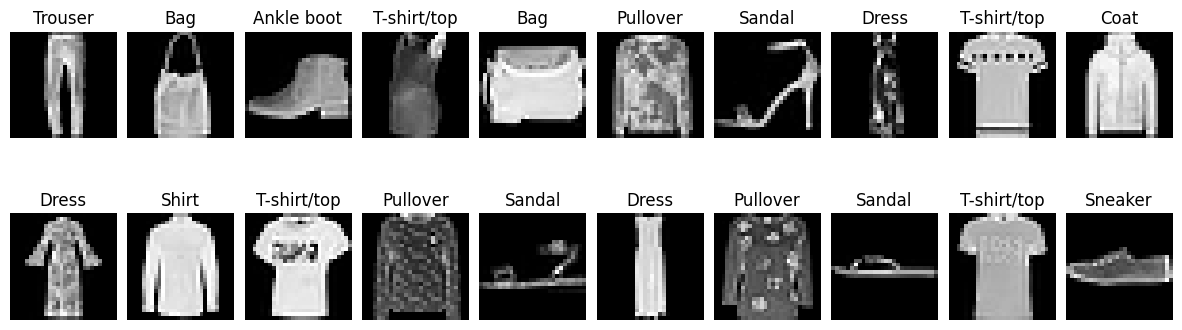

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline

fig, ax = plt.subplots(2,10,figsize=(15,4.5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for j in range(0,2):
    for i in range(0, 10):
        ax[j,i].imshow(X_train[i+j*10], cmap='gray')
        ax[j,i].set_title(class_names[y_train[i+j*10]])
        ax[j,i].axis('off')
plt.show()

## Persiapkan dataset

In [4]:
# normalisasi data citra 
X_train = X_train.astype('float32') / 255.
X_val   = X_val.astype('float32') / 255.
X_test  = X_test.astype('float32') / 255.

# **4. Keras Tuner**
Library untuk tuning hyperparameter
---
<img src = "https://i.ibb.co/4RyZpZ2/keras-tuner.png" height="200" align = "center">

Keras tuner is a hyperparameter optimization library (Hyperparameter tuner) built specifically for `tf.keras` with TensorFlow 2.0. It was introduced at the Google I/O 2019 event. 

This library is intended for AI practitioners, hypertuner algorithm creators, and model designers. It can be as simple as possible to build a model with a clean and easy API. Keras Tuner comes with Bayesian Optimization, Hyperband, and Random Search algorithms built-in, and is also designed to be easy for researchers to extend in order to experiment with new search algorithms.

read more: [Documentation](https://keras-team.github.io/keras-tuner/), [github repository](https://github.com/keras-team/keras-tuner)


## 4.1- Installation

In [5]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.3 MB/s eta 0:00:00


In [6]:
import kerastuner as kt

<ipython-input-6-5fd8096cdee5>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


---
## 4.2 - Define Hyperparameter Range

In this example, we'll only use a Two-Layer Neural Network, and we're going to tune the layer width (number of hidden neuron), type of activation function, and the learning rate. Both hyperparameter range and the model need to be defined inside a method to feed into the tuner object. So in this part, we'll see the explanations first, then later the actual implementations.

### Layer Width

For this hyperparameter, we'll use grid choice to iterate from 128 to 256 with 64 increment. For that we use `Int()` method as follow

```python 
    ch_unit = hp.Int('units', min_value=128, max_value=256, step=64) 
```

### Activation Function
For the activation function, let's try `relu`, `tanh`, and `sigmoid` function. For that we use `Choice()` method as follow
```python
    ch_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'], default='relu')
```

### Learning Rate
The learning rate represents how fast the learning algorithm progresses.The learning rate may, in fact, be the most important hyperparameter to configure for your model. Unfortunately, we cannot analytically calculate the optimal learning rate for a given model on a given dataset. Instead, a good (or good enough) learning rate must be discovered via trial and error. 

Arguably, it is actually not the best thing to tune learning rate using grid search. As mentioned by Bergstra and Bengio in [Random Search for Hyper-Parameter Optimization](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf), “randomly chosen trials are more efficient for hyper-parameter optimization than trials on a grid”. 

<table>
  <tr><td  align="center">
    <img src="https://cs231n.github.io/assets/nn3/gridsearchbad.jpeg" width="50%" 
         alt="Grid vs Random Layout.">
  </td></tr>
  <tr><td align="center">
    <b>Figure:</b> Grid vs Random Layout illustration from [Random Search for Hyper-Parameter Optimization](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf).
  </td></tr>
</table>

Usually, the learning rate is chosen on a log scale. Intuitively, this is because learning rate have multiplicative effects on the training dynamics. This prior knowledge can be incorporated in the search through the setting of the sampling method:

```python
    ch_learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG', default=1e-3)
```

# **5. Define Model**

Now to define a function to build the model. We still use the usual Keras API, but feed in the choice for each hyperparameter. The function takes an argument hp from which we can use to sample the hyperparameters.

> <font color='red'>**LATIHAN**: </font> **Lengkapi Kode Berikut di Bagian '???'!** 

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

def build_model(hp):
  
    ch_unit          = hp.Int('units', min_value=128, max_value=256, step=64) 
    ch_activation    = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'], default='relu')
    ch_learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG', default=1e-3)

    # define model
    model = Sequential([
                Flatten(input_shape=(28,28)), 
                Dense(units=ch_unit, activation=ch_activation),   # hidden layer 1
                Dense(10, activation='softmax')     # layer output
            ])

    # compile model
    model.compile(
        optimizer = tf.keras.optimizers.Adam(ch_learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    
    return model

# **6. Inisialisasi Tuner**
---
The Keras Tuner has four tuners available - **RandomSearch**, **Hyperband**,  **Bayesian Optimization** and **Sklearn**. In this exercise, we'll focus on random search and Hyperband. We won't go into theory, but for Hyperband, its main idea is to optimize Random Search in terms of search time.

In here we can specify the model-building function, the name of the `objective` (metrics) to optimize, the total number of trials (`max_trials`) to test, and the number of models that should be built and fit for each trial (`executions_per_trial`). 

Similar to K-Fold Cross Validation, the purpose of having multiple executions per trial is to reduce results variance and therefore be able to more accurately assess the performance of a model.



In [14]:
from kerastuner.tuners import RandomSearch, Hyperband

---
## 6.1 - Random Search Tuner
The most intuitive way to perform hyperparameter tuning is to randomly sample hyperparameter combinations and test them out. 

### Initialize Random Tuner
Here we will do the tuning experiment 4 times, with the best model selection metrics based on validation accuracy. The `max_trials` variable represents the number of hyperparameter combinations that will be tested by the tuner, while the `execution_per_trial` variable is the number of models that should be built and fit for each trial for robustness purposes.

In [15]:
tuner_random = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=4,
    executions_per_trial=2,
    directory=join(root_path, 'random_search'),
    project_name='mnist_random'
    )

Once the model and the tuner are set up, we can view the search space summary

In [16]:
tuner_random.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


### Run Random Tuning Process

Now we can start the Optimization for just 5 epochs. The arguments for the search method are the same as those used for `tf.keras.model.fit` 

Depend on how big your search space is, it might take a while.

In [17]:
tuner_random.search(X_train, y_train,
             batch_size=256,
             epochs=5,
             validation_data=(X_val, y_val))

Trial 4 Complete [00h 00m 12s]
val_accuracy: 0.8655000030994415

Best val_accuracy So Far: 0.8655000030994415
Total elapsed time: 00h 00m 58s


### View the Search Summary

Finally, the search results can be summarized and used

In [18]:
tuner_random.results_summary()

Results summary
Results in gdrive/My Drive/Colab Notebooks/Deep Learning Labs/Pertemuan 2/random_search/mnist_random
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 3 summary
Hyperparameters:
units: 256
activation: relu
learning_rate: 0.0004752264742088846
Score: 0.8655000030994415

Trial 2 summary
Hyperparameters:
units: 192
activation: tanh
learning_rate: 0.0006331000531343112
Score: 0.8620833456516266

Trial 0 summary
Hyperparameters:
units: 192
activation: tanh
learning_rate: 0.0004875934610700417
Score: 0.8601388931274414

Trial 1 summary
Hyperparameters:
units: 256
activation: relu
learning_rate: 5.7559938015649796e-05
Score: 0.8236388862133026


### Show The Best Hyperparameter

In [19]:
import tensorflow.keras.backend as K

# Retrieve the best model.
best_model_random = tuner_random.get_best_models(num_models=1)[0]
best_model_random.summary()

print('Best Initial Learning Rate =', K.eval(best_model_random.optimizer.lr))
print('Activation Function used   =', best_model_random.layers[1].get_config()['activation'],)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________
Best Initial Learning Rate = 0.00047522646
Activation Function used   = relu


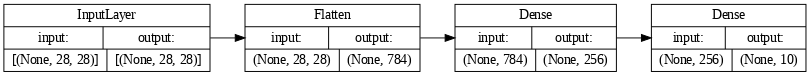

In [20]:
from tensorflow.keras.utils import plot_model

plot_model(best_model_random, 
           to_file='best_random.png', 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='LR',
           dpi=70
          )

---
## 6.2 - Hyperband Tuner
Hyperband is an optimized version of random search which uses early-stopping to speed up the hyperparameter tuning process. The Hyperband tuning algorithm uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model. 


The main idea is to fit a large number of models for a small number of epochs and to only continue training for the models achieving the highest accuracy on the validation set. The `max_epochs` variable is the max number of epochs that a model can be trained for.

### Initialize Hyperband Tuner
Here we will do the tuning experiment 4 times, with the best model selection metrics based on validation accuracy.

In [21]:
tuner_hyperband = Hyperband(
    build_model,
    max_epochs=5,
    objective='val_accuracy',
    executions_per_trial=2,
    directory=join(root_path, 'hyperband'),
    project_name='mnist_hyperband'
)

Once the model and the tuner are set up, we can view the search space summary

In [22]:
tuner_hyperband.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


### Run Hyperband Tuning Process

Now we can start the Optimization for just 5 epochs. 

In [23]:
tuner_hyperband.search(X_train, y_train,
             batch_size=256,
             epochs=5,
             validation_data=(X_val, y_val))

Trial 10 Complete [00h 00m 12s]
val_accuracy: 0.846916675567627

Best val_accuracy So Far: 0.8773610889911652
Total elapsed time: 00h 01m 39s


### View the Search Summary

Finally, the search results can be summarized and used

In [24]:
tuner_hyperband.results_summary()

Results summary
Results in gdrive/My Drive/Colab Notebooks/Deep Learning Labs/Pertemuan 2/hyperband/mnist_hyperband
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0007 summary
Hyperparameters:
units: 192
activation: tanh
learning_rate: 0.005400022266224203
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.8773610889911652

Trial 0006 summary
Hyperparameters:
units: 256
activation: sigmoid
learning_rate: 0.006629185696387153
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0004
Score: 0.874527782201767

Trial 0008 summary
Hyperparameters:
units: 128
activation: tanh
learning_rate: 0.000373392456707989
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.8556388914585114

Trial 0005 summary
Hyperparameters:
units: 256
activation: tanh
learning_rate: 0.006571970090025509
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0000
Sco

### Show The Best Hyperparameter

In [25]:
# Retrieve the best model.
best_model_hyperband = tuner_hyperband.get_best_models(num_models=1)[0]
best_model_hyperband.summary()

print('Best Initial Learning Rate =', K.eval(best_model_hyperband.optimizer.lr))
print('Activation Function used   =', best_model_random.layers[1].get_config()['activation'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 192)               150720    
                                                                 
 dense_1 (Dense)             (None, 10)                1930      
                                                                 
Total params: 152,650
Trainable params: 152,650
Non-trainable params: 0
_________________________________________________________________
Best Initial Learning Rate = 0.0054000225
Activation Function used   = relu


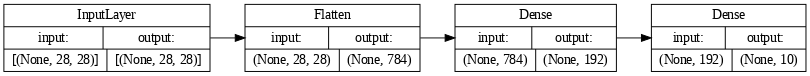

In [26]:
from tensorflow.keras.utils import plot_model

plot_model(best_model_hyperband, 
           to_file='best_hyperband.png', 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='LR',
           dpi=70
          )

# **7. Model Evaluation**

Model hasil dari tuning dengan Random Search

In [27]:
loss, accuracy = best_model_random.evaluate(X_test, y_test)
print('Validation Accuracy (Random Search) =', accuracy)

313/313 [==============================] - 1s 2ms/step - loss: 0.4150 - accuracy: 0.8511
Validation Accuracy (Random Search) = 0.8511000275611877


Model hasil dari tuning dengan Hyperband

In [28]:
loss, accuracy = best_model_hyperband.evaluate(X_test, y_test)
print('Validation Accuracy (Hyperband) =', accuracy)

313/313 [==============================] - 1s 3ms/step - loss: 0.3703 - accuracy: 0.8679
Validation Accuracy (Hyperband) = 0.867900013923645


---
### View Result
Now to visualize some of the model's predictions:

Hasil prediksi model dari tuning dengan Random Search 

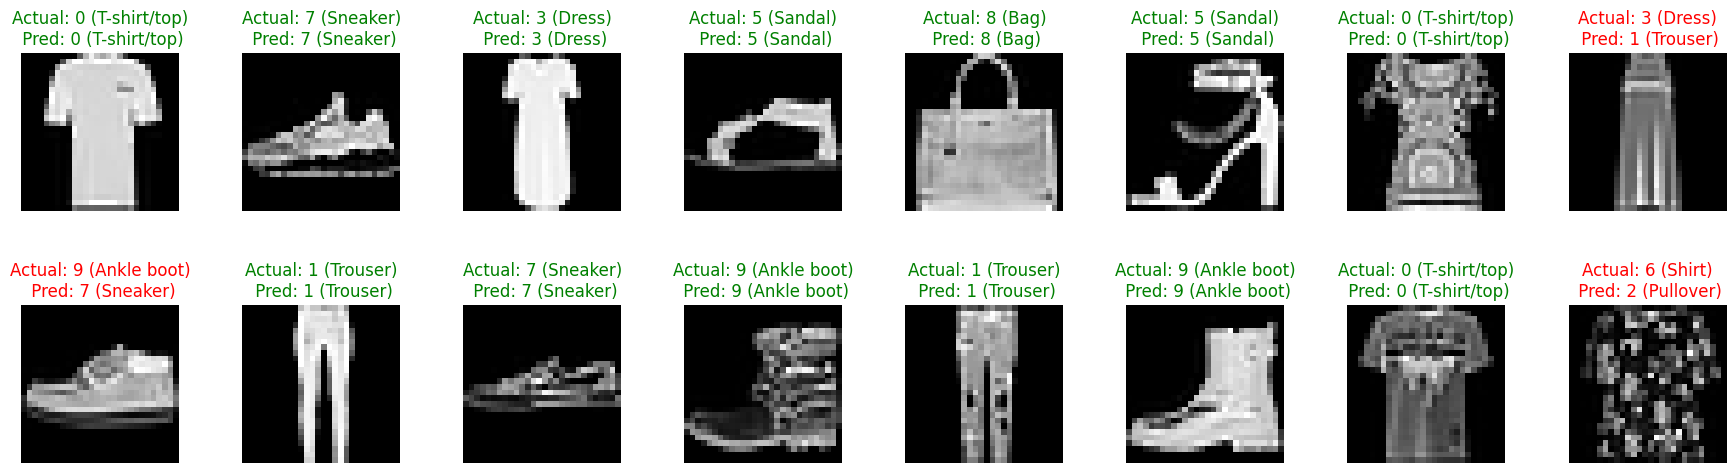

In [29]:
y_pred = best_model_random.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred, axis=1)

fig, ax = plt.subplots(2,8,figsize=(22,6))
fig.subplots_adjust(hspace=0.2, wspace=0.4)

for j in range(0,2):
    for i in range(0, 8):

        img_index = np.random.randint(0, X_test.shape[0])
        ax[j,i].imshow(X_test[img_index], cmap='gray')

        actual_label    = int(y_test[img_index])
        predicted_label = int(y_pred[img_index])

        color = 'red'
        if actual_label == predicted_label:
            color = 'green'

        ax[j,i].set_title("Actual: {} ({})\n Pred: {} ({})".format(
            actual_label, class_names[actual_label], predicted_label, class_names[predicted_label]
            ), color=color)
        ax[j,i].axis('off')
plt.show()

Hasil prediksi model dari tuning dengan Hyperband

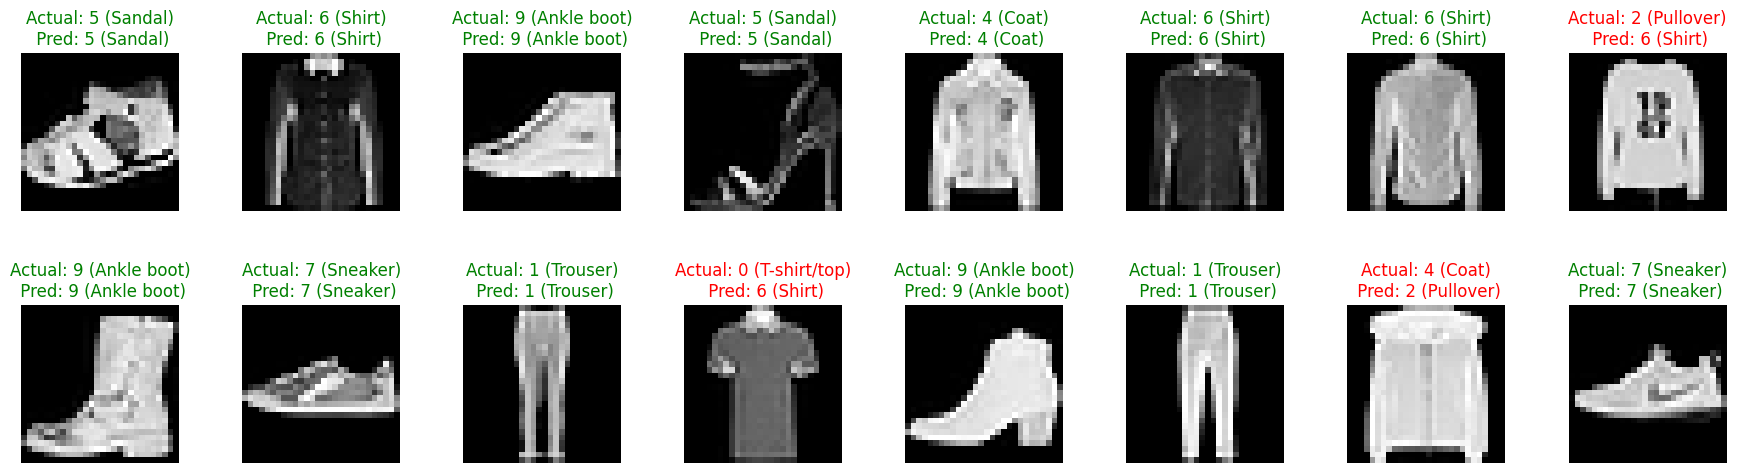

In [30]:
y_pred = best_model_hyperband.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred, axis=1)

fig, ax = plt.subplots(2,8,figsize=(22,6))
fig.subplots_adjust(hspace=0.2, wspace=0.4)

for j in range(0,2):
    for i in range(0, 8):

        img_index = np.random.randint(0, X_test.shape[0])
        ax[j,i].imshow(X_test[img_index], cmap='gray')

        actual_label    = int(y_test[img_index])
        predicted_label = int(y_pred[img_index])

        color = 'red'
        if actual_label == predicted_label:
            color = 'green'

        ax[j,i].set_title("Actual: {} ({})\n Pred: {} ({})".format(
            actual_label, class_names[actual_label], predicted_label, class_names[predicted_label]
            ), color=color)
        ax[j,i].axis('off')
plt.show()

# **8. Post-Test**
1. Copy kode di bagian **5. Define Model** yang sudah anda perbaiki 
2. Buat teks baru dibawah kode bagian 5. Define Model tersebut dan diisi dengan teks **Model Post Test**
3. Buat kode baru dibawah teks tersebut lalu paste kode dari bagian 5 di soal nomor 1 tadi. 
4. **Tambahkan 2 hidden layer** setelah hidden layer pertama dan sebelum layer output. 
5. **Ubah rentang pencarian nilai hyperparameter dari ch_units** yang ada di kode tersebut. Karena sekarang total ada 3 hidden layer maka buat 3 ch_units dengan konfigurasi yang berbeda. Beri nama 'units_1', 'units_2', dan 'units_3' seperti pada contoh kode.
6. Kira-kira menjadi seperti kode dibawah ini. Anda lengkapi kode yang masih tanda tanya '???'. 
```python 
def build_model(hp):
    # contoh konfigurasi ch_units
    ch_unit1         = hp.Int('units_1', min_value=64, max_value=512, step=64)
    ch_unit2         = ???
    ch_unit3         = ???
    ch_activation    = ???
    ch_learning_rate = ???

    # define model
    model = Sequential([
                Flatten(input_shape=(28,28)), 
                Dense(units=???, activation=???), # hidden layer 1
                Dense(units=???, activation=???), # hidden layer 2
                Dense(units=???, activation=???), # hidden layer 3
                Dense(10, activation='softmax') # layer output
            ])

    # compile model
    model.compile(
        optimizer = tf.keras.optimizers.Adam(???),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    
    return model
```
6. Jalankan kode di bagian Model Post Test tersebut.
7. **Modifikasi bagian 6.1 - Initialize Random Tuner**. Ubah lokasi penyimpanan model hasil pelatihan dari **'random_search' menjadi 'random_search_post_test'** 
```python 
tuner_random = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=4,
    executions_per_trial=2,
    directory=join(root_path, 'random_search'), # << ubah bagian ini
    project_name='mnist_random'
    )
```
8. **Modifikasi bagian 6.2 - Initialize Hyperband Tuner**. Ubah lokasi penyimpanan model hasil pelatihan dari **'hyperband' menjadi 'hyperband_post_test'** 
```python 
tuner_hyperband = Hyperband(
    build_model,
    max_epochs=5,
    objective='val_accuracy',
    executions_per_trial=2,
    directory=join(root_path, 'hyperband'),  # << ubah bagian ini
    project_name='mnist_hyperband'
)
```
9. Jalankan semua kode di bagian 6 dan 7.
10. Amati hasil akurasi pengujiannya dan hasil prediksinya!

##Model Posttest

In [31]:
def build_model(hp):
 # contoh konfigurasi ch_units
 ch_unit1         = hp.Int('units_1', min_value=64, max_value=512, step=64)
 ch_unit2         = hp.Int('units_2', min_value=32, max_value=256, step=64)
 ch_unit3         = hp.Int('units_3', min_value=128, max_value=512, step=64)
 ch_activation    = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'], default='relu')
 ch_learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG', default=1e-3)

 # define model
 model = Sequential([
             Flatten(input_shape=(28,28)), 
             Dense(units=ch_unit1, activation=ch_activation), # hidden layer 1
             Dense(units=ch_unit2, activation=ch_activation), # hidden layer 2
             Dense(units=ch_unit3, activation=ch_activation), # hidden layer 3
             Dense(10, activation='softmax') # layer output
         ])

 # compile model
 model.compile(
     optimizer = tf.keras.optimizers.Adam(ch_learning_rate),
     loss='sparse_categorical_crossentropy',
     metrics=['accuracy'])

 return model

##Initialize Random Tuner

In [32]:
tuner_random = RandomSearch(
 build_model,
 objective='val_accuracy',
 max_trials=4,
 executions_per_trial=2,
 directory=join(root_path, 'random_search_post_test'), # << ubah bagian ini
 project_name='mnist_random'
 )

In [35]:
tuner_random.search(X_train, y_train,
             batch_size=256,
             epochs=5,
             validation_data=(X_val, y_val))

Trial 4 Complete [00h 00m 16s]
val_accuracy: 0.6693611145019531

Best val_accuracy So Far: 0.8712222278118134
Total elapsed time: 00h 01m 07s


In [36]:
tuner_random.results_summary()

Results summary
Results in gdrive/My Drive/Colab Notebooks/Deep Learning Labs/Pertemuan 2/random_search_post_test/mnist_random
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 1 summary
Hyperparameters:
units_1: 512
units_2: 224
units_3: 256
activation: sigmoid
learning_rate: 0.0042944721167486035
Score: 0.8712222278118134

Trial 0 summary
Hyperparameters:
units_1: 256
units_2: 96
units_3: 320
activation: sigmoid
learning_rate: 0.00019359405093705243
Score: 0.7691111266613007

Trial 2 summary
Hyperparameters:
units_1: 512
units_2: 224
units_3: 128
activation: sigmoid
learning_rate: 5.214425461684572e-05
Score: 0.6861666738986969

Trial 3 summary
Hyperparameters:
units_1: 64
units_2: 224
units_3: 384
activation: sigmoid
learning_rate: 0.0001254532900438075
Score: 0.6693611145019531


In [37]:
# Retrieve the best model.
best_model_random = tuner_random.get_best_models(num_models=1)[0]
best_model_random.summary()

print('Best Initial Learning Rate =', K.eval(best_model_random.optimizer.lr))
print('Activation Function used   =', best_model_random.layers[1].get_config()['activation'],)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 224)               114912    
                                                                 
 dense_2 (Dense)             (None, 256)               57600     
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 577,002
Trainable params: 577,002
Non-trainable params: 0
_________________________________________________________________
Best Initial Learning Rate = 0.0042944723
Activati

##Initialize Hyperband

In [38]:
tuner_hyperband = Hyperband(
 build_model,
 max_epochs=5,
 objective='val_accuracy',
 executions_per_trial=2,
 directory=join(root_path, 'hyperband'),  # << ubah bagian ini
 project_name='hyperband_post_test'
)

In [39]:
tuner_hyperband.search(X_train, y_train,
             batch_size=256,
             epochs=5,
             validation_data=(X_val, y_val))

Trial 10 Complete [00h 00m 19s]
val_accuracy: 0.828555554151535

Best val_accuracy So Far: 0.8724166750907898
Total elapsed time: 00h 02m 21s


In [40]:
tuner_hyperband.results_summary()

Results summary
Results in gdrive/My Drive/Colab Notebooks/Deep Learning Labs/Pertemuan 2/hyperband/hyperband_post_test
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0005 summary
Hyperparameters:
units_1: 320
units_2: 96
units_3: 320
activation: relu
learning_rate: 0.0007928907265661397
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0004
Score: 0.8724166750907898

Trial 0006 summary
Hyperparameters:
units_1: 448
units_2: 96
units_3: 448
activation: tanh
learning_rate: 0.00011770717938345076
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0000
Score: 0.8585555553436279

Trial 0004 summary
Hyperparameters:
units_1: 320
units_2: 96
units_3: 320
activation: relu
learning_rate: 0.0007928907265661397
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.8504722416400909

Trial 0000 summary
Hyperparameters:
units_1: 448
units_2: 96
units_3: 448
activation: t

In [41]:
# Retrieve the best model.
best_model_hyperband = tuner_hyperband.get_best_models(num_models=1)[0]
best_model_hyperband.summary()

print('Best Initial Learning Rate =', K.eval(best_model_hyperband.optimizer.lr))
print('Activation Function used   =', best_model_random.layers[1].get_config()['activation'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 320)               251200    
                                                                 
 dense_1 (Dense)             (None, 96)                30816     
                                                                 
 dense_2 (Dense)             (None, 320)               31040     
                                                                 
 dense_3 (Dense)             (None, 10)                3210      
                                                                 
Total params: 316,266
Trainable params: 316,266
Non-trainable params: 0
_________________________________________________________________
Best Initial Learning Rate = 0.0007928907
Activati

##Model Evalutaion


In [42]:
loss, accuracy = best_model_random.evaluate(X_test, y_test)
print('Validation Accuracy (Random Search) =', accuracy)

313/313 [==============================] - 1s 3ms/step - loss: 0.3794 - accuracy: 0.8614
Validation Accuracy (Random Search) = 0.8614000082015991


In [43]:
loss, accuracy = best_model_hyperband.evaluate(X_test, y_test)
print('Validation Accuracy (Hyperband) =', accuracy)

313/313 [==============================] - 1s 3ms/step - loss: 0.3750 - accuracy: 0.8639
Validation Accuracy (Hyperband) = 0.8639000058174133


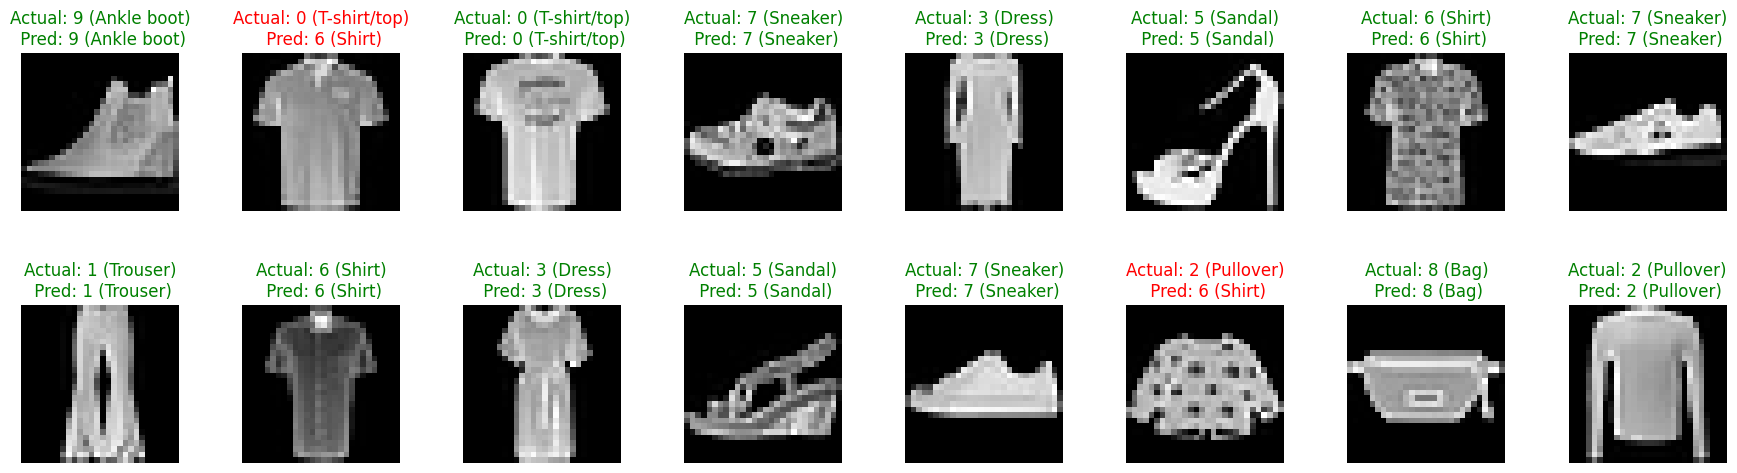

In [44]:
y_pred = best_model_random.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred, axis=1)

fig, ax = plt.subplots(2,8,figsize=(22,6))
fig.subplots_adjust(hspace=0.2, wspace=0.4)

for j in range(0,2):
    for i in range(0, 8):

        img_index = np.random.randint(0, X_test.shape[0])
        ax[j,i].imshow(X_test[img_index], cmap='gray')

        actual_label    = int(y_test[img_index])
        predicted_label = int(y_pred[img_index])

        color = 'red'
        if actual_label == predicted_label:
            color = 'green'

        ax[j,i].set_title("Actual: {} ({})\n Pred: {} ({})".format(
            actual_label, class_names[actual_label], predicted_label, class_names[predicted_label]
            ), color=color)
        ax[j,i].axis('off')
plt.show()

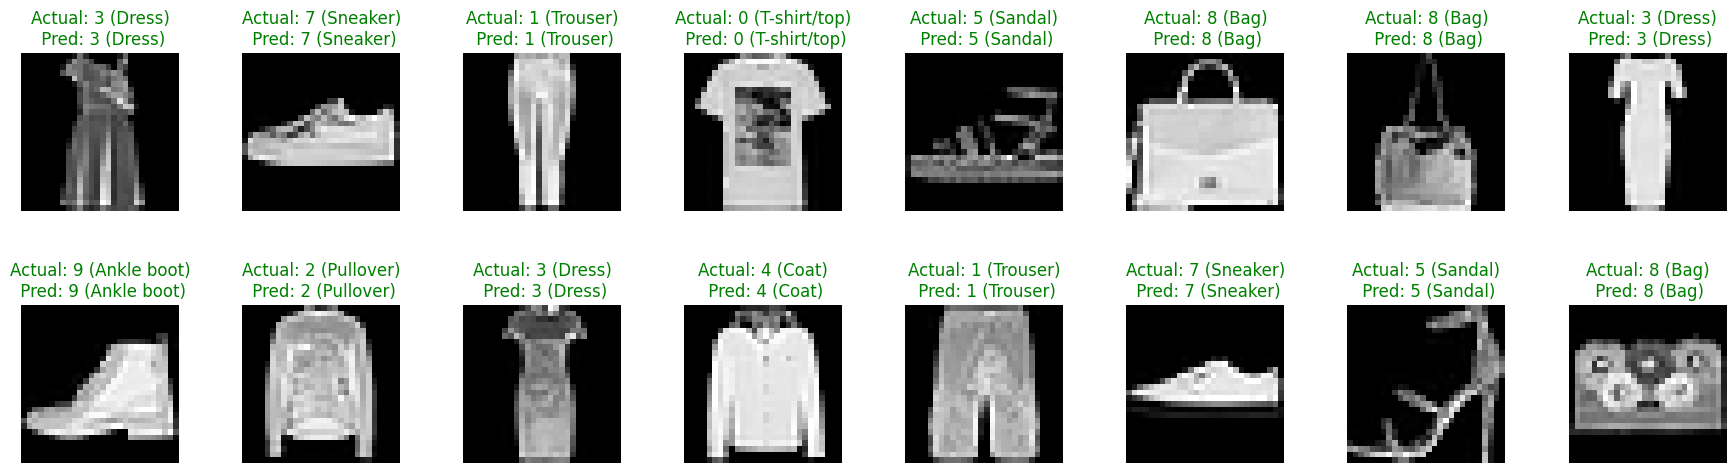

In [45]:
y_pred = best_model_hyperband.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred, axis=1)

fig, ax = plt.subplots(2,8,figsize=(22,6))
fig.subplots_adjust(hspace=0.2, wspace=0.4)

for j in range(0,2):
    for i in range(0, 8):

        img_index = np.random.randint(0, X_test.shape[0])
        ax[j,i].imshow(X_test[img_index], cmap='gray')

        actual_label    = int(y_test[img_index])
        predicted_label = int(y_pred[img_index])

        color = 'red'
        if actual_label == predicted_label:
            color = 'green'

        ax[j,i].set_title("Actual: {} ({})\n Pred: {} ({})".format(
            actual_label, class_names[actual_label], predicted_label, class_names[predicted_label]
            ), color=color)
        ax[j,i].axis('off')
plt.show()

##NOTED
**Hyperband Tuner** best val_accuracy : 0.8724166750907898

**Random Search Tuner** best val_accuracy : 0.8724166750907898

Validation Accuracy (**Random Search**) = 0.8614000082015991


